In [1]:
import os
from pathlib import Path
import pandas as pd

from es_sfgtools.data_mgmt.data_handler import DataHandler
pride_path = Path.home() / ".PRIDE_PPPAR_BIN"
os.environ["PATH"] += os.pathsep + str(pride_path)
import matplotlib.pyplot as plt
%matplotlib ipympl

from nptyping import NDArray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import NavigationToolbar2Tk

import sys
sys.path.append("/Users/franklyndunbar/Project/SeaFloorGeodesy/gnatss/src")
import gnatss
from gnatss.ops.kalman import run_filter_simulation
import gnatss.constants as constants
import datetime

In [2]:
GPS_EPOCH = datetime.datetime(1980, 1, 6, 0, 0, 0)
J200_EPOCH = datetime.datetime(2000, 1, 1, 12, 0, 0)


def time_to_gpsweek_seconds(time: datetime.datetime) -> tuple[int, float]:
    """
    Convert a datetime object to GPS week and seconds of week.
    """

    # Calculate the difference in time
    delta = time - GPS_EPOCH

    # Total seconds since GPS epoch
    total_seconds = delta.total_seconds()

    # Calculate GPS week and seconds of week
    gps_week = int(total_seconds // (7 * 24 * 3600))
    seconds_of_week = total_seconds % (7 * 24 * 3600)

    return gps_week, seconds_of_week


def time_to_j200(time: datetime.datetime) -> float:
    """
    Convert a datetime object to Julian Date (JD) and then to J2000.
    """
    # Calculate the difference in time
    delta = time - J200_EPOCH

    # Total seconds since J2000 epoch
    total_seconds = delta.total_seconds()

    return total_seconds

In [3]:
main_dir = Path("/Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain")
dh = DataHandler(main_dir)

network = "cascadia-gorda"
station = "NCC1"
survey = "2024_A_1126"

dh.change_working_station(network=network, station=station, campaign=survey)



Built directory structure for cascadia-gorda NCC1 2024_A_1126
No date range set for cascadia-gorda, NCC1, 2024_A_1126
Creating TileDB arrays for NCC1
Consolidating existing TileDB arrays for NCC1
Changed working station to cascadia-gorda NCC1 2024_A_1126


In [4]:
print(dates:=dh.kin_position_tdb.get_unique_dates())

['2022-05-01' '2022-05-03' '2022-05-04' '2022-05-05' '2022-05-06'
 '2022-05-07' '2022-05-08' '2022-05-09' '2023-09-08' '2023-09-09'
 '2023-09-10' '2023-09-11' '2023-09-12' '2023-09-13' '2023-09-14']


In [5]:
kin_positions = dh.kin_position_tdb.read_df(dates[4], dates[5])
shotdata = dh.shotdata_tdb_pre.read_df(dates[4], dates[5])

In [6]:
kin_positions.head()

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms
0,2022-05-06 00:00:00.000,41.659099,235.062105,-28.1257,-2.733000e+06,-3.912147e+06,4.217372e+06,11,1.4,5.380650
1,2022-05-06 00:00:00.999,41.659097,235.062103,-27.1692,-2.733000e+06,-3.912147e+06,4.217372e+06,11,1.4,4.074118
2,2022-05-06 00:00:01.999,41.659097,235.062104,-27.6261,-2.733000e+06,-3.912147e+06,4.217372e+06,11,1.4,3.511849
3,2022-05-06 00:00:02.999,41.659093,235.062116,-28.1595,-2.732999e+06,-3.912147e+06,4.217371e+06,11,1.4,3.025103
4,2022-05-06 00:00:04.000,41.659087,235.062120,-28.9036,-2.732999e+06,-3.912148e+06,4.217370e+06,11,1.4,2.820126


In [7]:
shotdata.head()

,pingTime,transponderID,head0,pitch0,roll0,head1,pitch1,roll1,east0,north0,...,east_std1,north_std1,up_std1,returnTime,tt,dbv,xc,snr,tat,isUpdated
0,1.651795e+09,IR5209,131.765137,-1.059283,1.794902,132.588379,3.650667,0.141165,-2.733001e+06,-3.912147e+06,...,7.788,8.154,23.0,1.651795e+09,1.636898,-30,68,15.0,0.2,0
1,1.651795e+09,IR5209,150.774673,-0.521324,-3.328873,143.650452,3.974211,1.485776,-2.733006e+06,-3.912151e+06,...,7.804,8.155,23.0,1.651795e+09,1.634609,-10,76,36.0,0.2,0
2,1.651795e+09,IR5209,130.266647,3.410717,-2.966369,132.388718,4.405166,0.993787,-2.733012e+06,-3.912156e+06,...,7.845,8.155,23.0,1.651795e+09,1.631912,-10,88,37.0,0.2,0
3,1.651795e+09,IR5209,141.069656,-13.314089,8.962605,137.545593,3.645947,2.781657,-2.733016e+06,-3.912161e+06,...,7.843,8.131,23.0,1.651795e+09,1.627579,-10,80,38.0,0.2,0
4,1.651795e+09,IR5209,137.902283,-3.733109,-6.117216,138.326904,5.988830,-2.783530,-2.733020e+06,-3.912166e+06,...,7.828,8.125,23.0,1.651795e+09,1.624502,-13,78,34.0,0.2,0


In [8]:
shotdata = shotdata[shotdata.transponderID=="IR5209"]
shotdata.pingTime = pd.to_datetime(shotdata.pingTime, unit='s')
shotdata.returnTime = pd.to_datetime(shotdata.returnTime, unit='s')

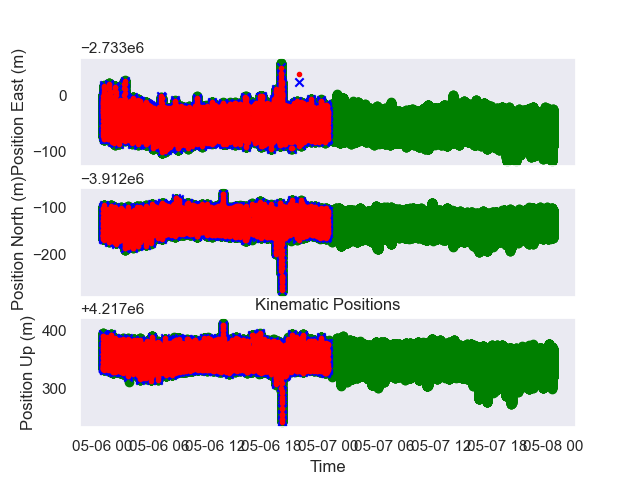

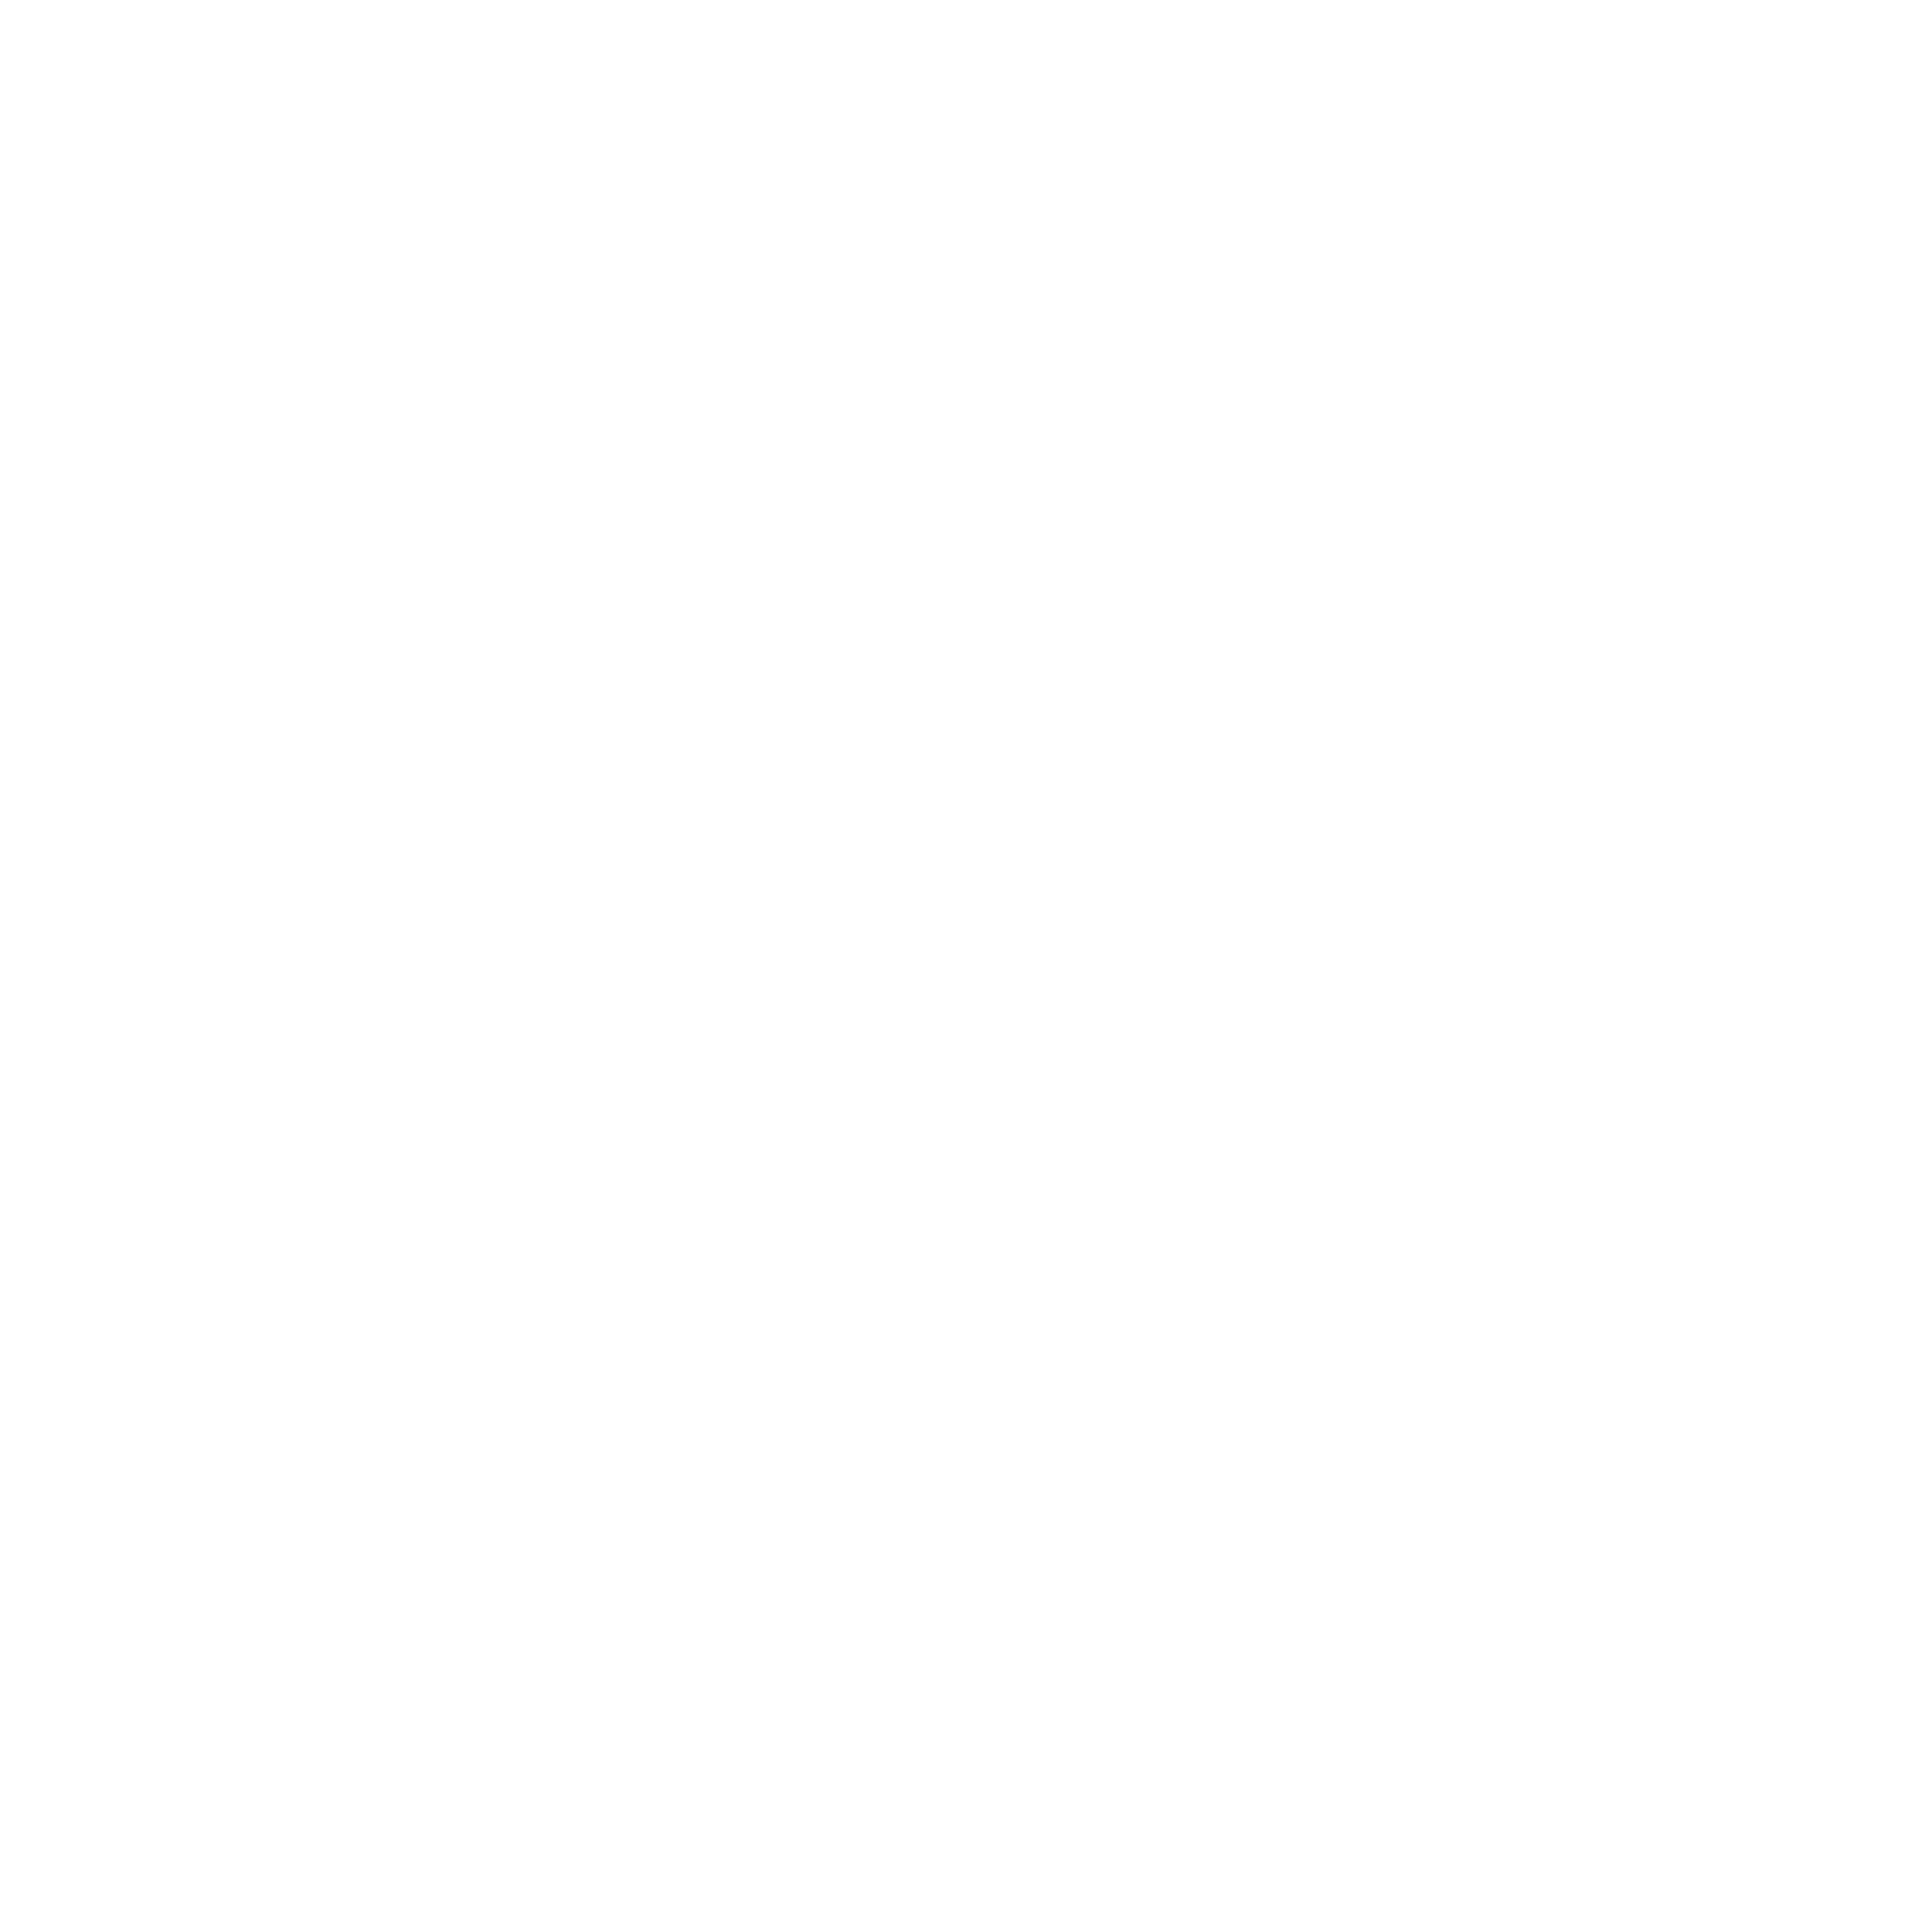

In [9]:
plt.ion()  # Turn on interactive mode
plt.figure(figsize=(16*2, 16*2))
fig,axes = plt.subplots(3,1,sharex=True)

axes[0].scatter(kin_positions['time'], kin_positions["east"], label='East',color='green')
axes[0].scatter(shotdata['pingTime'], shotdata["east0"], label='East',color='blue',marker='x')
axes[0].scatter(shotdata['returnTime'], shotdata["east1"], label='East Return',color='red',marker='.')
axes[0].set_ylabel('Position East (m)')
# axes[0].legend()
axes[0].grid()

axes[1].scatter(kin_positions['time'], kin_positions["north"], label='North',color='green')
axes[1].scatter(shotdata['pingTime'], shotdata["north0"], label='North',color='blue',marker='x')
axes[1].scatter(shotdata['returnTime'], shotdata["north1"], label='North Return',color='red',marker='.')
axes[1].set_ylabel('Position North (m)')
# axes[1].legend()
axes[1].grid()

axes[2].scatter(kin_positions['time'], kin_positions["up"], label='Up',color='green')
axes[2].scatter(shotdata['pingTime'], shotdata["up0"], label='Up',color='blue',marker='x')
axes[2].scatter(shotdata['returnTime'], shotdata["up1"], label='Up Return',color='red',marker='.')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Position Up (m)')
# axes[2].legend()
axes[2].grid()

plt.title('Kinematic Positions')
plt.show()

In [10]:
gps_df = kin_positions.copy()
gps_df.time = gps_df.time.apply(lambda x: time_to_j200(x))
east_velocity = gps_df.east.diff() / gps_df.time.diff()
north_velocity = gps_df.north.diff() / gps_df.time.diff()
up_velocity = gps_df.up.diff() / gps_df.time.diff()

gps_df["ant_x"] = gps_df["east"]
gps_df["ant_y"] = gps_df["north"]
gps_df["ant_z"] = gps_df["up"]

gps_df["east"] = east_velocity
gps_df["north"] = north_velocity
gps_df["up"] = up_velocity

gps_df["ant_sigx"] = .5
gps_df["ant_sigy"] = .5
gps_df["ant_sigz"] = .5

gps_df["rho_xy"] = 0
gps_df["rho_xz"] = 0
gps_df["rho_yz"] = 0

gps_df["east_sig"] = 1
gps_df["north_sig"] = 1
gps_df["up_sig"] = 1

gps_df["v_sden"] = 1
gps_df["v_sdeu"] = 1
gps_df["v_sdnu"] = 1
gps_df["source"] = 'KINEMATIC'

In [11]:
position_df_0 = shotdata[["pingTime", "east0", "north0", "up0","head0","pitch0","roll0","east_std0","north_std0","up_std0"]]
position_df_1 = shotdata[["returnTime", "east1", "north1", "up1","head1","pitch1","roll1","east_std1","north_std1","up_std1"]]

east_velocity_0 = (position_df_0["east0"].diff() / position_df_0["pingTime"].apply(lambda x: x.timestamp()).diff()).abs()
north_velocity_0 = (position_df_0["north0"].diff() / position_df_0["pingTime"].apply(lambda x: x.timestamp()).diff()).abs()
up_velocity_0 = (position_df_0["up0"].diff() / position_df_0["pingTime"].apply(lambda x: x.timestamp()).diff()).abs()


In [12]:
east_velocity_0.describe()

count    5572.000000
mean        0.525618
std         0.286881
min         0.000022
25%         0.309172
50%         0.529474
75%         0.708216
max         3.063533
dtype: float64

In [ ]:

east_velocity_1 = (position_df_1["east1"].diff() / position_df_1["returnTime"].apply(lambda x: x.timestamp()).diff()).abs()
north_velocity_1 = (position_df_1["north1"].diff() / position_df_1["returnTime"].apply(lambda x: x.timestamp()).diff()).abs()
up_velocity_1 = (position_df_1["up1"].diff() / position_df_1["returnTime"].apply(lambda x: x.timestamp()).diff()).abs()

position_df_0 = position_df_0.rename(columns={"east0": "ant_x", "north0": "ant_y", "up0": "ant_z"})

position_df_1 = position_df_1.rename(columns={"east1": "ant_x", "north1": "ant_y", "up1": "ant_z"})

position_df_0 = position_df_0.rename(columns={"east_std0": "ant_sigx", "north_std0": "ant_sigy", "up_std0": "ant_sigz"})

position_df_1 = position_df_1.rename(columns={"east_std1": "ant_sigx", "north_std1": "ant_sigy", "up_std1": "ant_sigz"})

position_df_0 = position_df_0.rename(columns={"head0": "heading", "pitch0": "pitch", "roll0": "roll"})
position_df_1 = position_df_1.rename(columns={"head1": "heading", "pitch1": "pitch", "roll1": "roll"})

position_df_0["east"] = east_velocity_0
position_df_0["north"] = north_velocity_0
position_df_0["up"] = up_velocity_0

position_df_0["east_sig"] = position_df_0["ant_sigx"]
position_df_0["north_sig"] = position_df_0["ant_sigy"]
position_df_0["up_sig"] = position_df_0["ant_sigz"]

position_df_1["east"] = east_velocity_1
position_df_1["north"] = north_velocity_1
position_df_1["up"] = up_velocity_1

position_df_1["east_sig"] = position_df_1["ant_sigx"]
position_df_1["north_sig"] = position_df_1["ant_sigy"]
position_df_1["up_sig"] = position_df_1["ant_sigz"]

position_df_0["rho_xy"] = position_df_0["rho_xz"] = position_df_0["rho_yz"] = 1
position_df_1["rho_xy"] = position_df_1["rho_xz"] = position_df_1["rho_yz"] = 1
position_df_0["v_sden"] =  position_df_0["v_sdeu"] = position_df_0["v_sdnu"] = 1
position_df_1["v_sden"] =  position_df_1["v_sdeu"] = position_df_1["v_sdnu"] = 1

position_df_0 = position_df_0.rename(columns={"pingTime": "time"})
position_df_1 = position_df_1.rename(columns={"returnTime": "time"})

position_df_0.time = pd.to_datetime(position_df_0.time, unit='s')
position_df_1.time = pd.to_datetime(position_df_1.time, unit='s')

position_df = pd.concat([position_df_0, position_df_1])
position_df.time = position_df.time.apply(lambda x: time_to_j200(x))
position_df["source"] = "PSEUDO"

In [14]:
gps_df.head()

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms,...,rho_xy,rho_xz,rho_yz,east_sig,north_sig,up_sig,v_sden,v_sdeu,v_sdnu,source
0,7.050672e+08,41.659099,235.062105,-28.1257,NaN,NaN,NaN,11,1.4,5.380650,...,0,0,0,1,1,1,1,1,1,KINEMATIC
1,7.050672e+08,41.659097,235.062103,-27.1692,-0.596497,-0.633934,0.472372,11,1.4,4.074118,...,0,0,0,1,1,1,1,1,1,KINEMATIC
2,7.050672e+08,41.659097,235.062104,-27.6261,0.267500,0.289800,-0.248100,11,1.4,3.511849,...,0,0,0,1,1,1,1,1,1,KINEMATIC
3,7.050672e+08,41.659093,235.062116,-28.1595,0.859700,-0.485100,-0.696200,11,1.4,3.025103,...,0,0,0,1,1,1,1,1,1,KINEMATIC
4,7.050672e+08,41.659087,235.062120,-28.9036,0.330370,-0.115584,-1.012088,11,1.4,2.820126,...,0,0,0,1,1,1,1,1,1,KINEMATIC


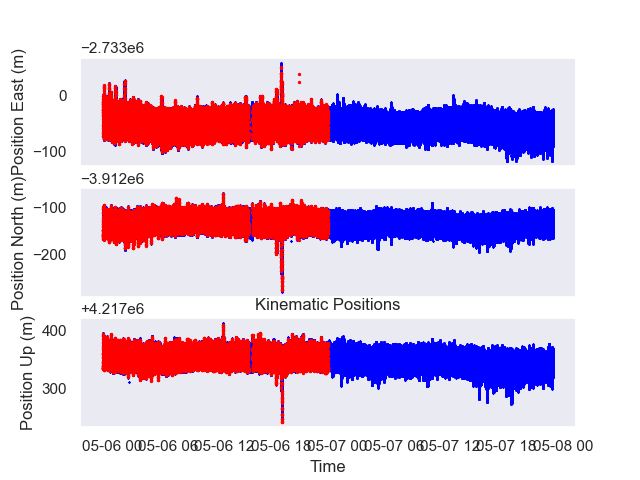

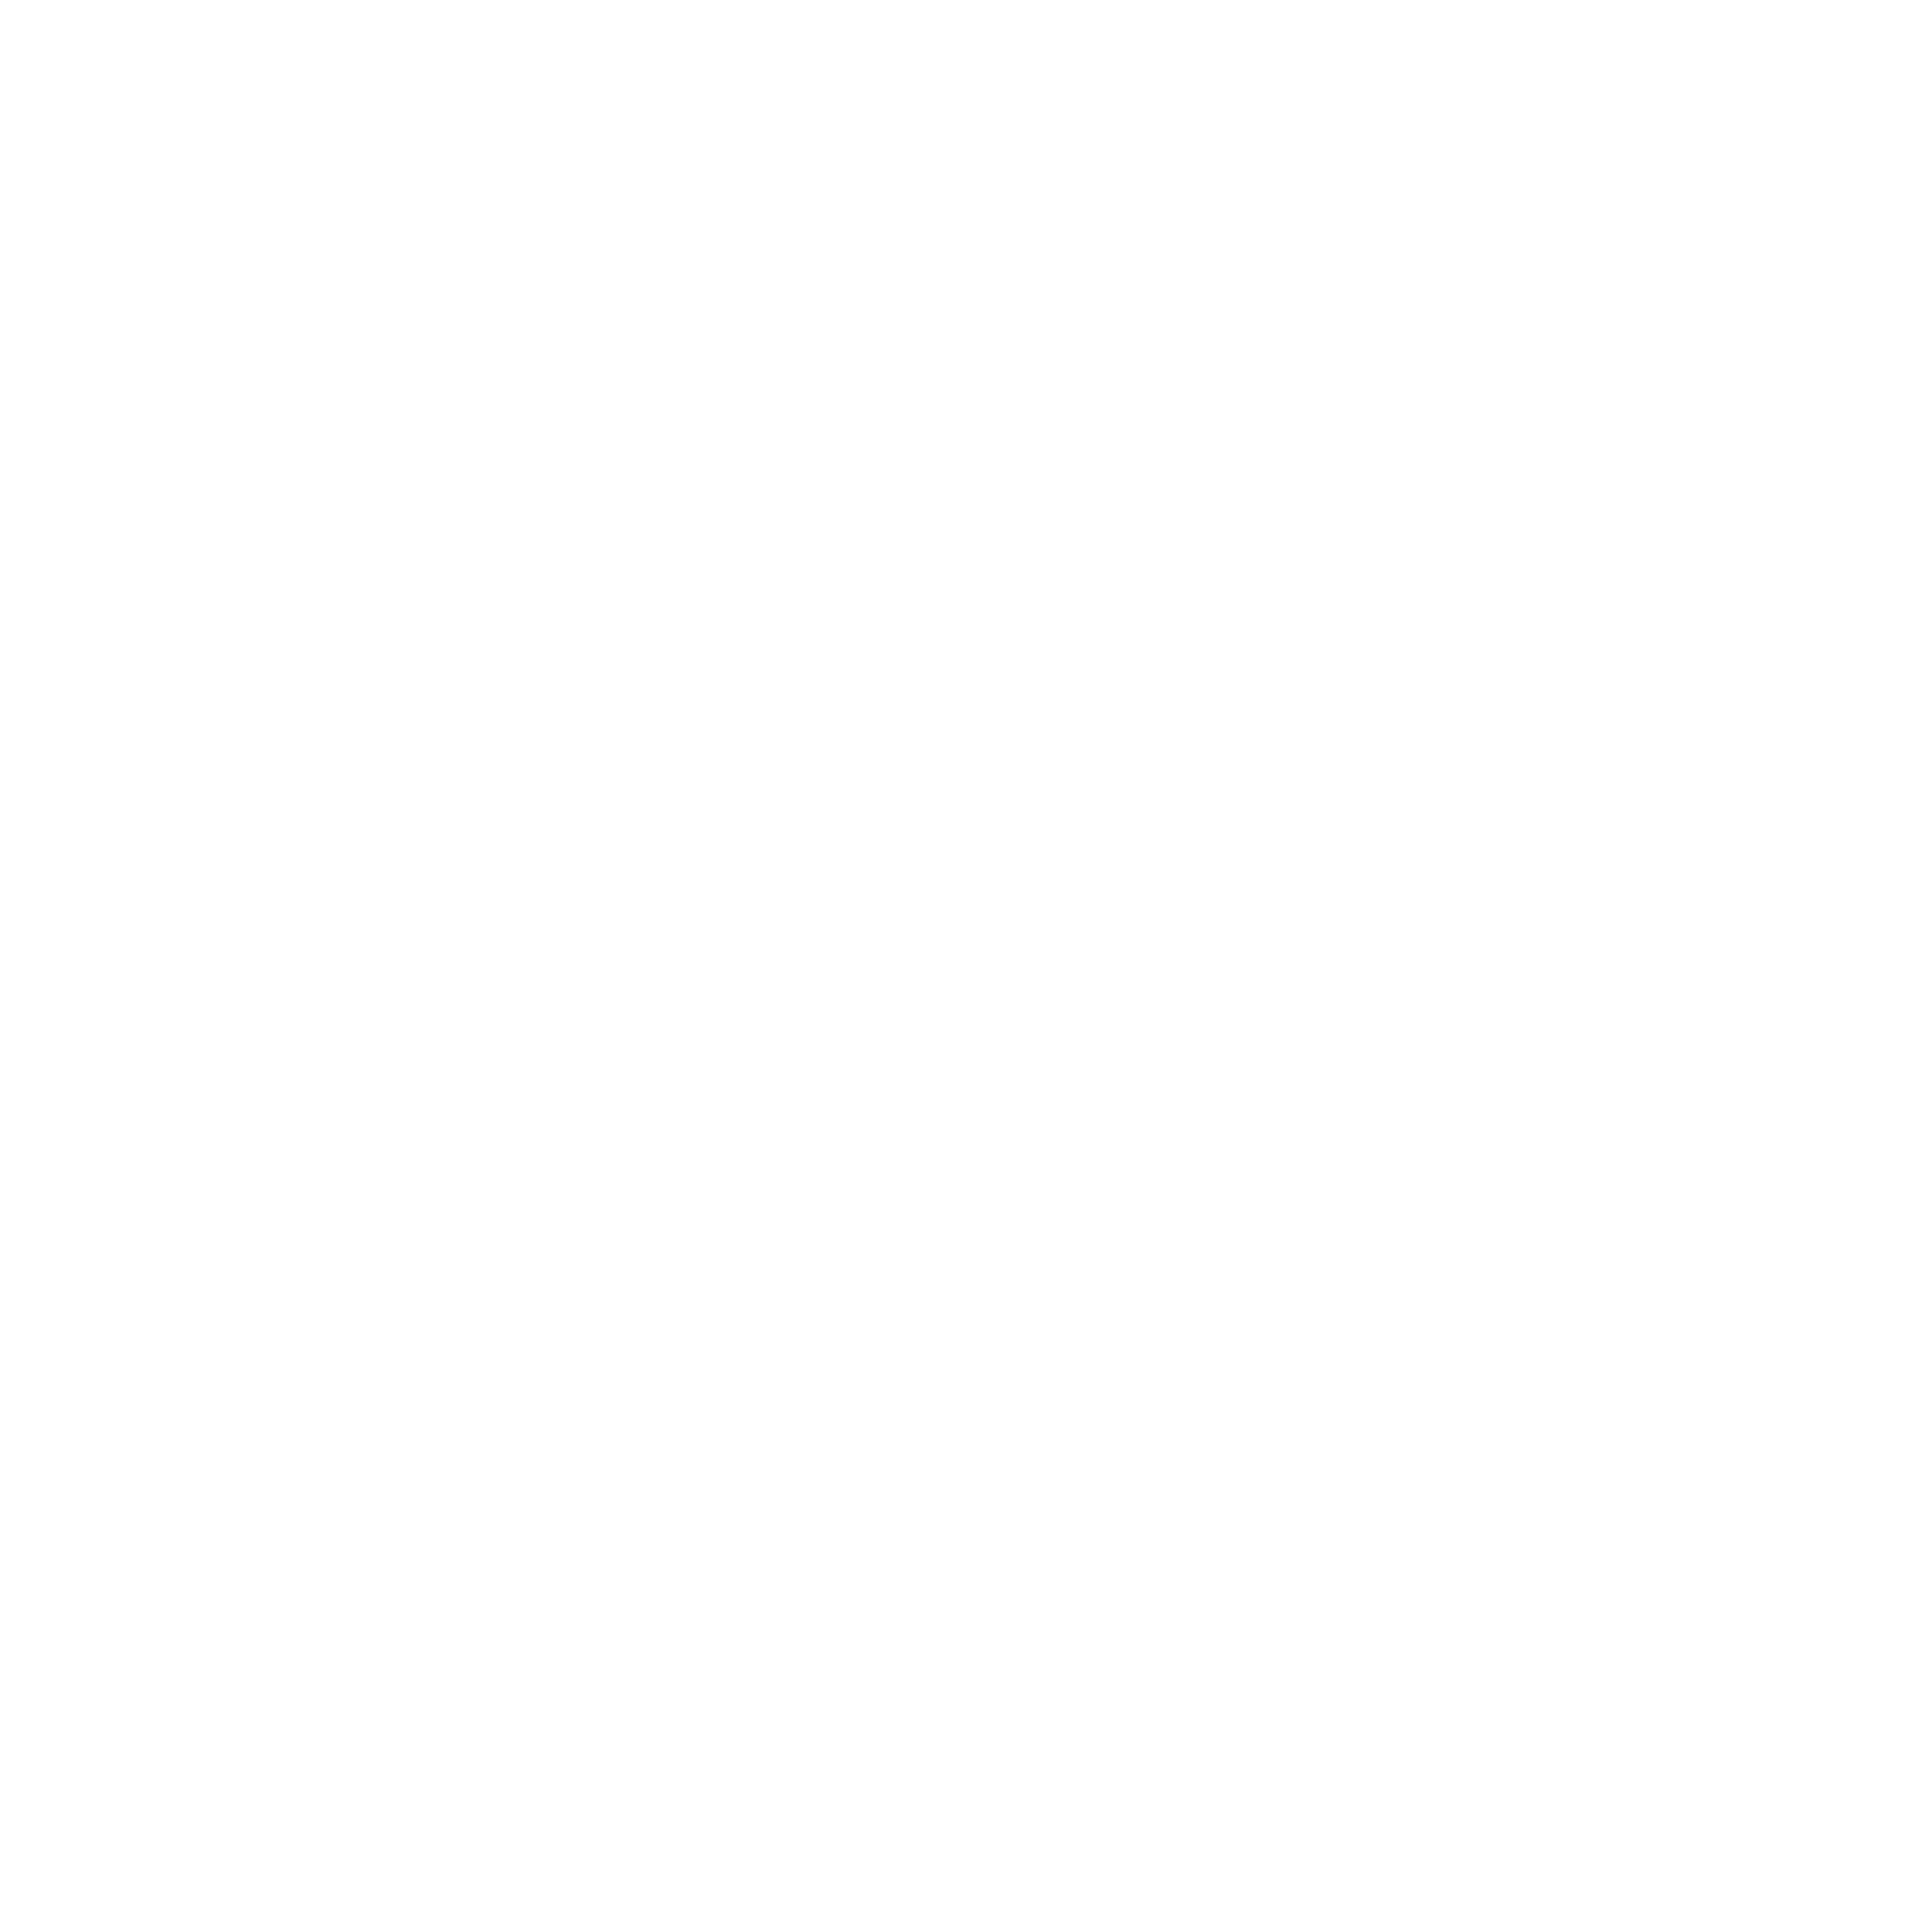

In [15]:
position_df_pseudo = position_df.copy()
position_df_pseudo.time += J200_EPOCH.timestamp()
position_df_pseudo.time = pd.to_datetime(position_df_pseudo.time, unit='s')

gps_df_pseudo = gps_df.copy()
gps_df_pseudo.time += J200_EPOCH.timestamp()
gps_df_pseudo.time = pd.to_datetime(gps_df_pseudo.time, unit='s')

plt.ion()  # Turn on interactive mode
plt.figure(figsize=(16 * 2, 16 * 2))
fig, axes = plt.subplots(3, 1, sharex=True)


axes[0].scatter(
   gps_df_pseudo["time"], gps_df_pseudo["ant_x"], label="East", color="blue", marker="x",s=1
)
axes[0].scatter(
    position_df_pseudo["time"],
    position_df_pseudo["ant_x"],
    label="East",
    color="red",
    s=2,
)

axes[0].set_ylabel("Position East (m)")
# axes[0].legend()
axes[0].grid()


axes[1].scatter(
    gps_df_pseudo["time"], gps_df_pseudo["ant_y"], label="North", color="blue", marker="x",s=1
)
axes[1].scatter(
    position_df_pseudo["time"],
    position_df_pseudo["ant_y"],
    label="North",
    color="red",
    s=2,
)

axes[1].set_ylabel("Position North (m)")
# axes[1].legend()
axes[1].grid()


axes[2].scatter(
    gps_df_pseudo["time"], gps_df_pseudo["ant_z"], label="Up", color="blue", marker="x",s=1
)
axes[2].scatter(
    position_df_pseudo["time"],
    position_df_pseudo["ant_z"],
    label="Up",
    color="red",
    s=2,
)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Position Up (m)")
# axes[2].legend()
axes[2].grid()

plt.title("Kinematic Positions")
plt.show()

In [16]:
df_all = pd.concat([position_df, gps_df])
column_order = ['time', 'east', 'north', 'up','ant_x', 'ant_y', 'ant_z','ant_sigx', 'ant_sigy', 'ant_sigz','rho_xy', 'rho_xz', 'rho_yz','east_sig', 'north_sig', 'up_sig','v_sden', 'v_sdeu', 'v_sdnu']
df_all = df_all[column_order].dropna()
#df_all.time = df_all.time.apply(lambda x: x - 18)


In [17]:
df_all = df_all.sort_values(by="time").reset_index(drop=True)



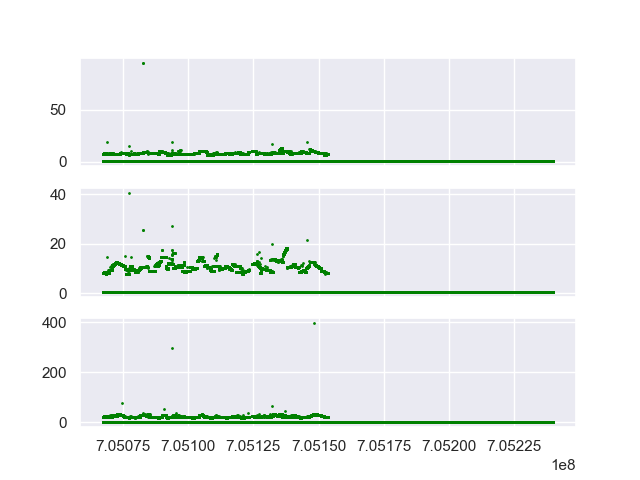

In [18]:
# plot covariance before filtering
fig,axes = plt.subplots(3,1,sharex=True)

axes[0].scatter(df_all['time'], df_all["ant_sigx"], label='East Sig',color='green',s=1)

axes[1].scatter(df_all['time'], df_all["ant_sigy"], label='North Sig',color='green',s=1)

axes[2].scatter(df_all['time'], df_all["ant_sigz"], label='Up Sig',color='green',s=1)



In [19]:
x, P, _, _ = run_filter_simulation(
    df_all.to_numpy(),
    constants.start_dt,
    constants.gnss_pos_psd,
    constants.vel_psd,
    constants.cov_err,
)

In [20]:
print(f"Start DT: {constants.start_dt}, GNSS_POS_PSD: {constants.gnss_pos_psd}, VEL_PSD: {constants.vel_psd}, COV_ERR: {constants.cov_err}")

Start DT: 0.05, GNSS_POS_PSD: 3.125e-05, VEL_PSD: 0.0025, COV_ERR: 0.25


In [21]:
# Positions covariance
ant_cov = P[:, :3, :3]
ant_cov_df = pd.DataFrame(ant_cov.reshape(ant_cov.shape[0], -1), columns=constants.ANT_GPS_COV)
ant_cov_df[[*constants.ANT_GPS_GEOCENTRIC_STD]] = ant_cov_df[
    [*constants.ANT_GPS_COV_DIAG]
].apply(np.sqrt)

ant_cov_df[constants.GPS_TIME] = df_all[constants.GPS_TIME]

# Smoothed positions
smoothed_results = pd.DataFrame(
    x.reshape(x.shape[0], -1)[:, :3],
    columns=constants.ANT_GPS_GEOCENTRIC,
)
# Add a unique index for merging
smoothed_results["merge_idx"] = smoothed_results.index
ant_cov_df["merge_idx"] = ant_cov_df.index

smoothed_results[constants.GPS_TIME] = df_all[constants.GPS_TIME].reset_index(drop=True)
ant_cov_df[constants.GPS_TIME] = df_all[constants.GPS_TIME].reset_index(drop=True)

smoothed_results = smoothed_results.merge(ant_cov_df, on="merge_idx", how="left", suffixes=('', '_cov'))
smoothed_results.time = smoothed_results.time.apply(lambda x: x + J200_EPOCH.timestamp())
smoothed_results.time = pd.to_datetime(smoothed_results.time, unit='s')


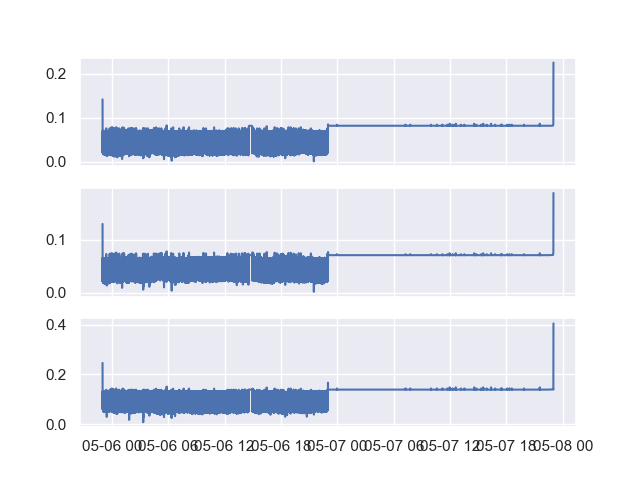

In [22]:
# plot antenna covariance in x,y,z
fig,axes = plt.subplots(3,1,sharex=True)
axes[0].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigx"], label="X")
axes[1].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigy"], label="Y")
axes[2].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigz"], label="Z")

In [23]:
position_df_new = position_df.copy()
position_df_new.time = position_df_new.time + J200_EPOCH.timestamp()
position_df_new.time = pd.to_datetime(position_df_new.time, unit='s')

gps_df.time = gps_df.time.apply(lambda x: x + J200_EPOCH.timestamp())
gps_df.time = pd.to_datetime(gps_df.time, unit='s')

In [24]:
gps_df = gps_df.sort_values(by="time").reset_index(drop=True)
position_df_new = position_df_new.sort_values(by="time").reset_index(drop=True)
smoothed_results = smoothed_results.sort_values(by="time").reset_index(drop=True)

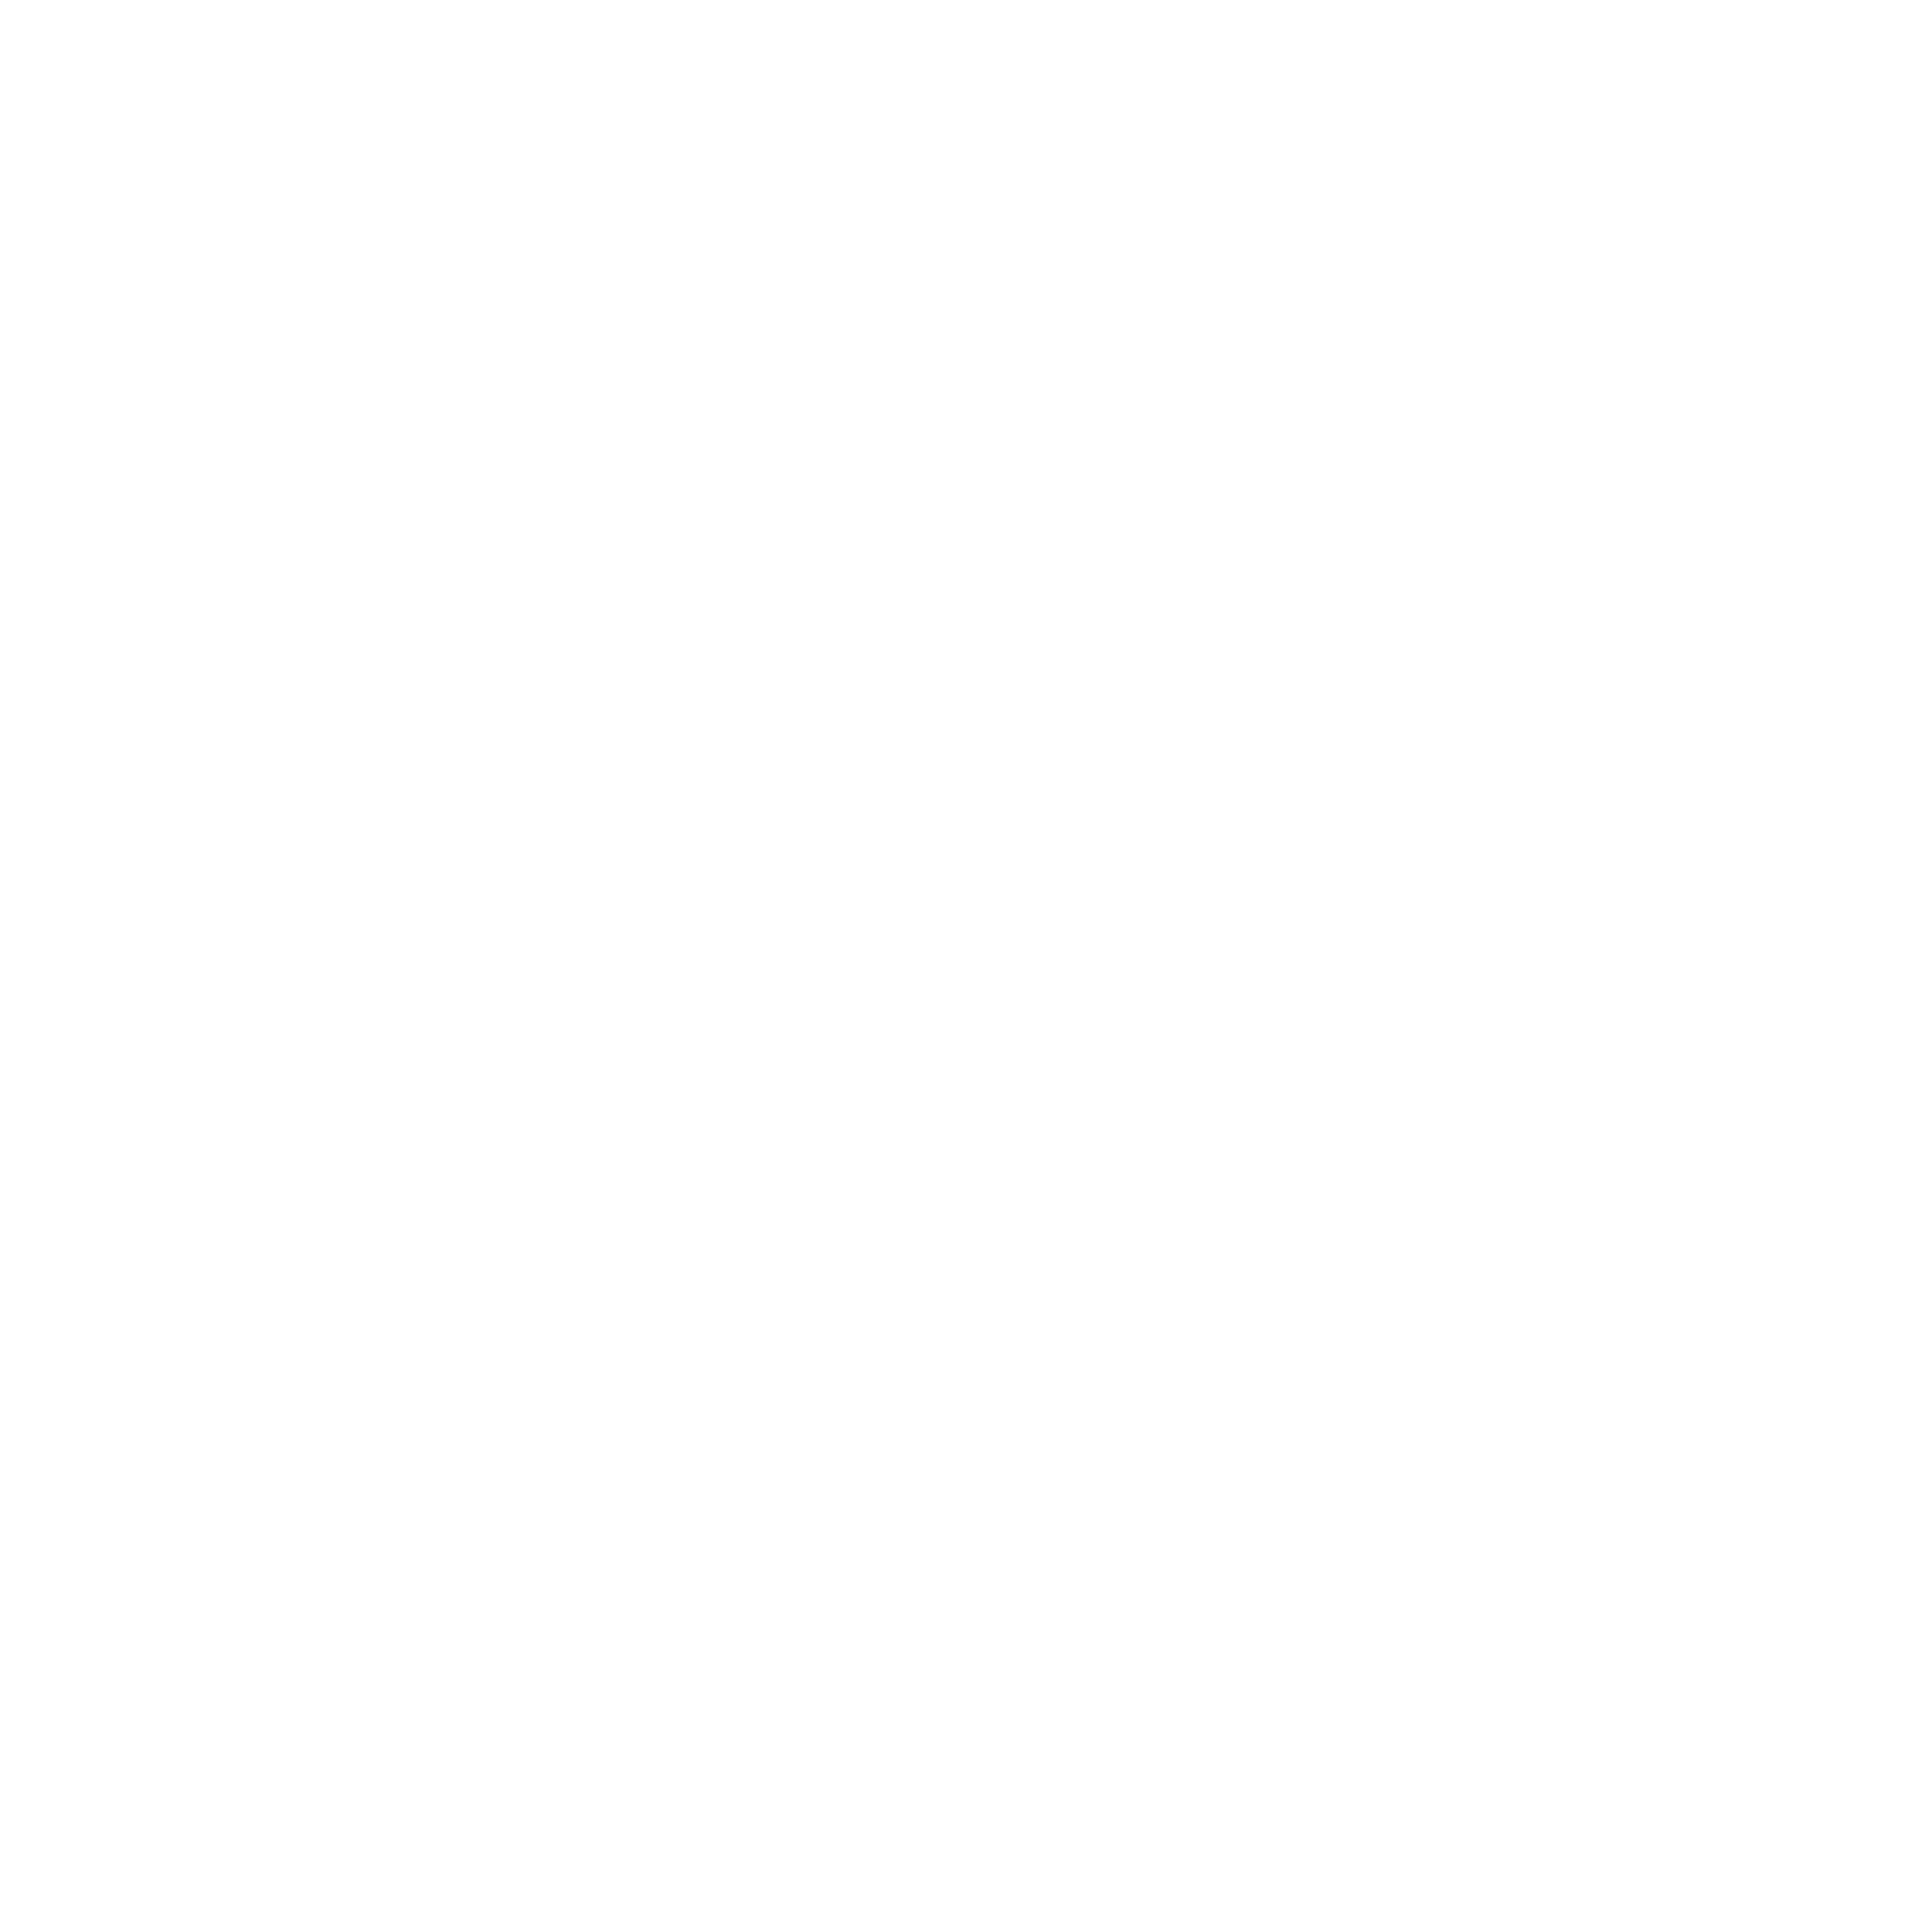

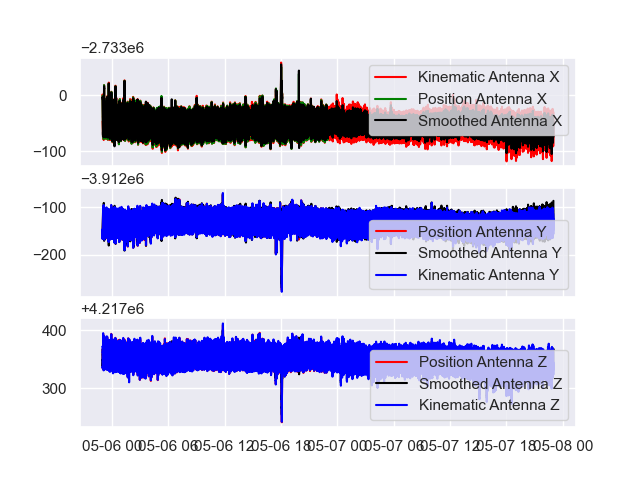

In [25]:
# compare position and results data
plt.ion()  # Turn on interactive mode
plt.figure(figsize=(16 * 2, 16 * 2))
fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].plot(gps_df['time'], gps_df["ant_x"], label='Kinematic Antenna X', color='red')
axes[0].plot(position_df_new['time'], position_df_new["ant_x"], label='Position Antenna X',color='green')
axes[0].plot(smoothed_results['time'], smoothed_results["ant_x"], label='Smoothed Antenna X', color='black')
axes[0].legend()

axes[1].plot(position_df_new['time'], position_df_new["ant_y"], label='Position Antenna Y', color='red')
axes[1].plot(smoothed_results['time'], smoothed_results["ant_y"], label='Smoothed Antenna Y', color='black')
axes[1].plot(gps_df['time'], gps_df["ant_y"], label='Kinematic Antenna Y', color='blue')
axes[1].legend()

axes[2].plot(position_df_new['time'], position_df_new["ant_z"], label='Position Antenna Z', color='red')
axes[2].plot(smoothed_results['time'], smoothed_results["ant_z"], label='Smoothed Antenna Z', color='black')
axes[2].plot(gps_df['time'], gps_df["ant_z"], label='Kinematic Antenna Z', color='blue')
axes[2].legend()